<a href="https://colab.research.google.com/github/sumedhaghosh1412/21AIC401T_Customer-Churn-Case-Study/blob/main/ISPA_Customer_Churn_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Customer Churn Prediction - Complete Analysis
# Inferential Statistics and Predictive Analytics


# SECTION 1: SETUP AND DATA LOADING

# Install required packages
!pip install CHAID scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, auc)
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [3]:
# Load dataset

from google.colab import files
df = pd.read_csv('Customer Churn Dataset.csv')

# Display basic information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nDataset Info:")
print(df.info())


DATASET OVERVIEW

Dataset Shape: (7043, 21)
Number of Rows: 7043
Number of Columns: 21

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic  

In [4]:

# DATA PREPARATION AND CLEANING

print("\n" + "="*80)
print("DATA CLEANING AND PREPARATION")
print("="*80)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")

# Handle TotalCharges (often has space issues in this dataset)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print(f"\nMissing values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")
    # Fill missing TotalCharges with median or drop
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Remove customerID if present (not needed for modeling)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Convert target variable
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    print(f"\nTarget Variable Distribution:")
    print(df['Churn'].value_counts())
    print(f"\nChurn Rate: {df['Churn'].mean()*100:.2f}%")

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in numerical_cols:
    numerical_cols.remove('Churn')

print(f"\nCategorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nNumerical Columns ({len(numerical_cols)}): {numerical_cols}")

# Handle outliers in numerical columns
print("\n" + "="*80)
print("OUTLIER DETECTION")
print("="*80)

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n{col}: {len(outliers)} outliers detected ({len(outliers)/len(df)*100:.2f}%)")


DATA CLEANING AND PREPARATION

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Number of Duplicate Rows: 0

Missing values in TotalCharges after conversion: 11

Target Variable Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Rate: 26.54%

Categorical Columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Numerical Columns (4): [


EXPLORATORY DATA ANALYSIS

Statistical Summary of Numerical Features:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2281.916928
std         0.368612    24.559481       30.090047   2265.270398
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    402.225000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000


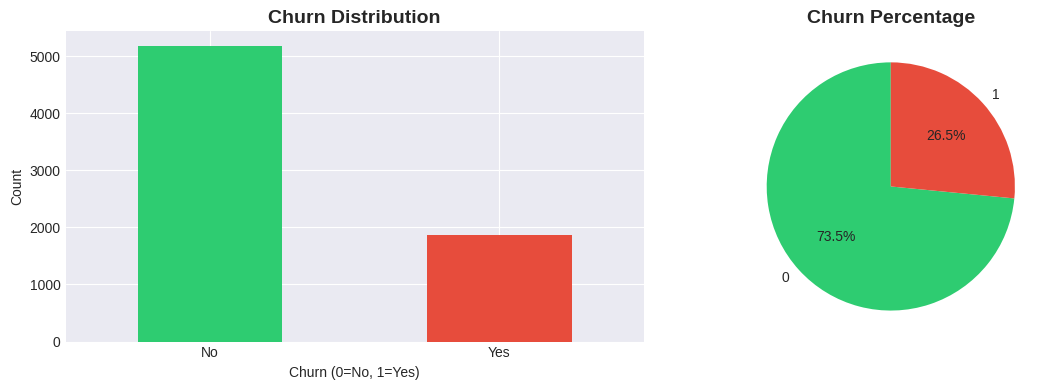

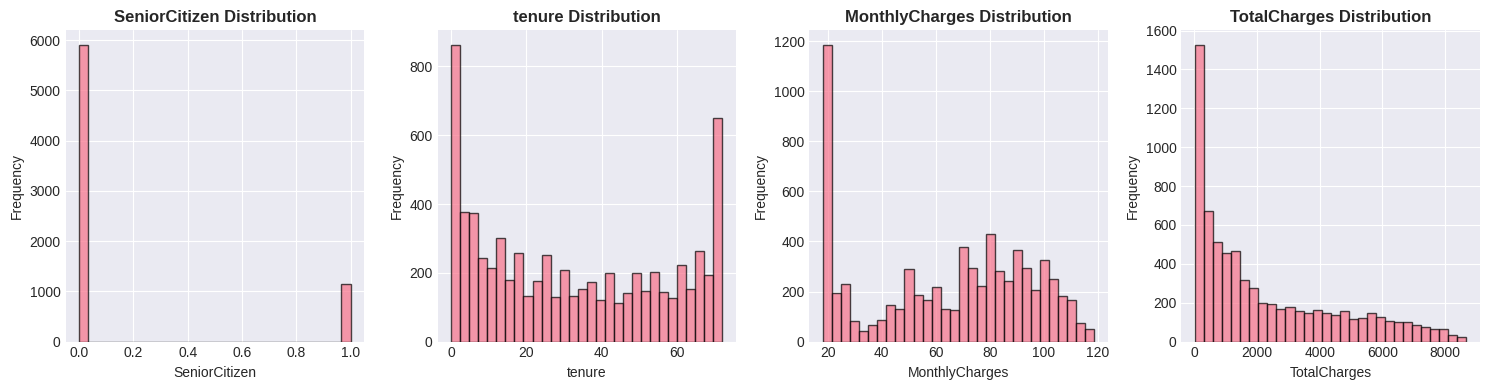

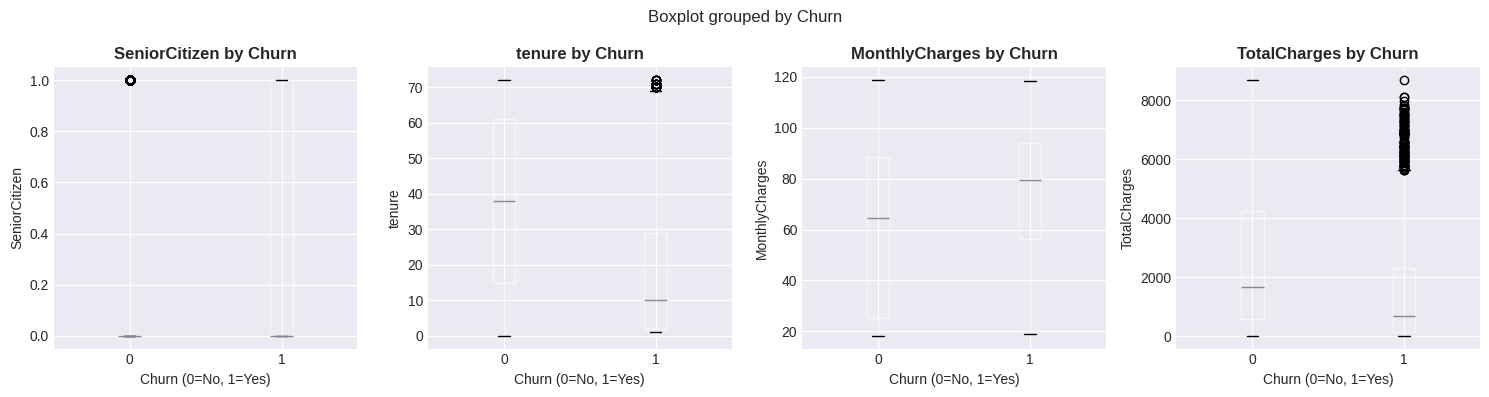

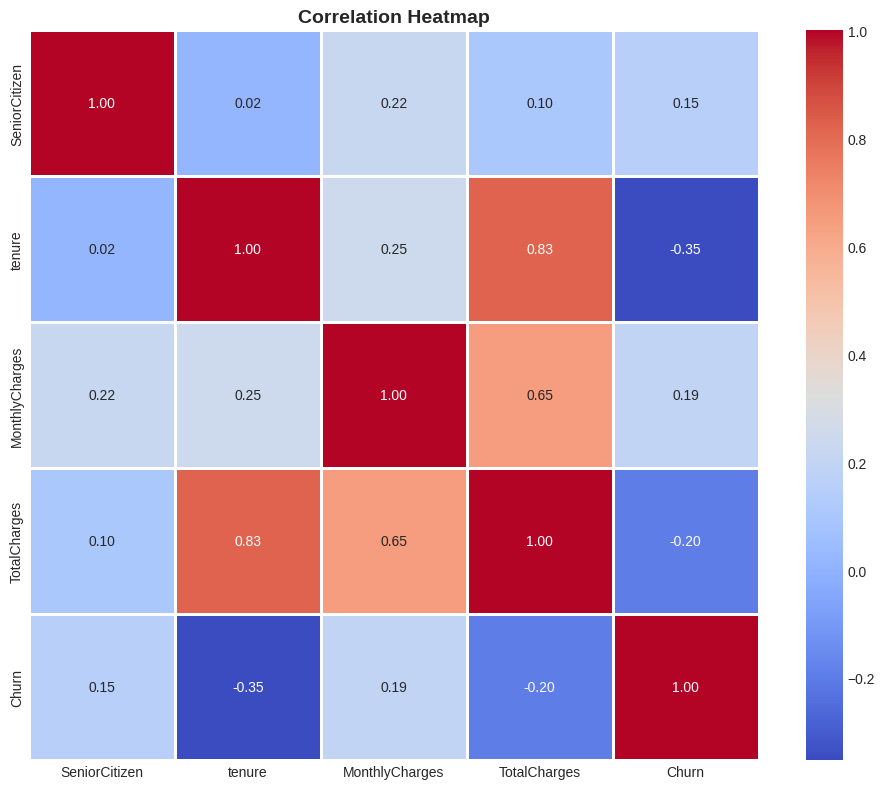

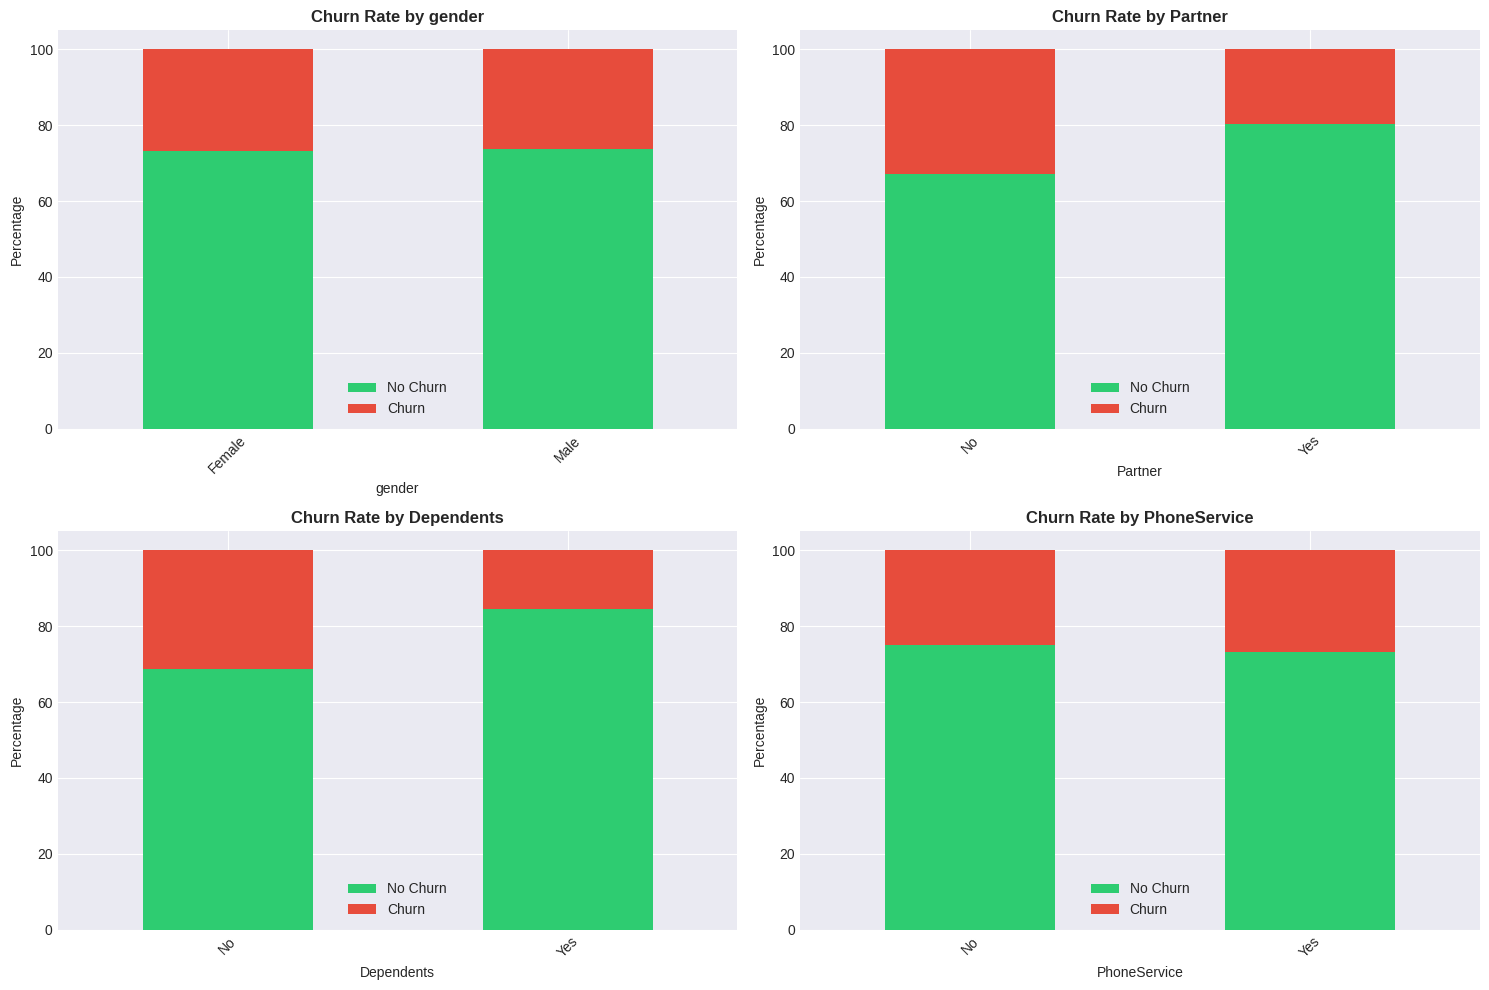

In [5]:

# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Statistical summary
print("\nStatistical Summary of Numerical Features:")
print(df[numerical_cols].describe())

# Visualization 1: Churn Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Churn'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

df['Churn'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                 colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Churn Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: Numerical Features Distribution
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    df[col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3: Churn vs Numerical Features
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{col} by Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn (0=No, 1=Yes)')
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.savefig('churn_vs_numerical.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 4: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols + ['Churn']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=1)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 5: Categorical Features vs Churn (top features)
if len(categorical_cols) > 0:
    n_cols = min(4, len(categorical_cols))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, col in enumerate(categorical_cols[:4]):
        churn_data = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
        churn_data.plot(kind='bar', stacked=True, ax=axes[idx],
                       color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'Churn Rate by {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(['No Churn', 'Churn'])
        axes[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('categorical_churn_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:

# SECTION 4: DATA PREPROCESSING FOR MODELING

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Create a copy for modeling
df_model = df.copy()

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

print("\nLabel Encoding completed for categorical variables")

# Define features and target
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

print(f"\nTraining Set Size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test Set Size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nChurn Rate in Training Set: {y_train.mean()*100:.2f}%")
print(f"Churn Rate in Test Set: {y_test.mean()*100:.2f}%")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nFeature scaling completed")




DATA PREPROCESSING

Label Encoding completed for categorical variables

Feature Matrix Shape: (7043, 19)
Target Vector Shape: (7043,)

Training Set Size: 5634 (80.0%)
Test Set Size: 1409 (20.0%)

Churn Rate in Training Set: 26.54%
Churn Rate in Test Set: 26.54%

Feature scaling completed



CHAID MODEL DEVELOPMENT

CHAID Model Performance:
Accuracy: 0.7850
ROC-AUC Score: 0.8238

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.85      1035
       Churn       0.60      0.57      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



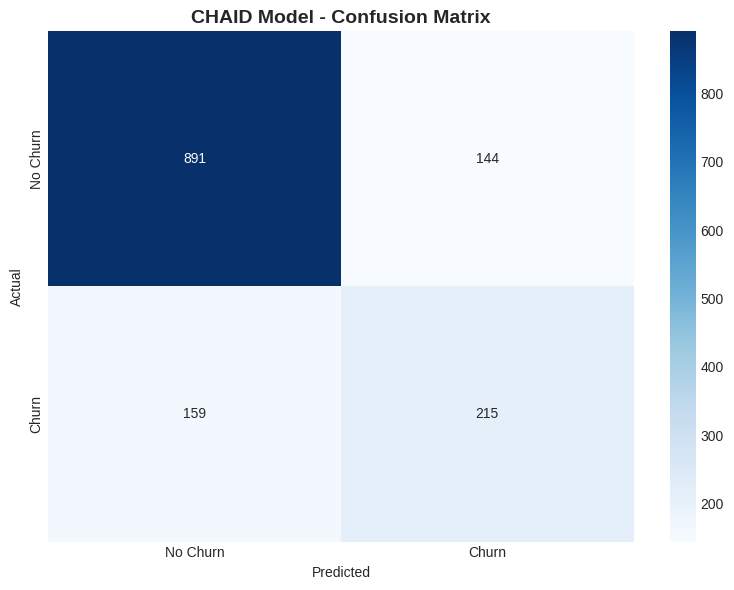


Top 10 Most Important Features (CHAID):
             Feature  Importance
14          Contract    0.532063
8     OnlineSecurity    0.140752
4             tenure    0.097186
7    InternetService    0.092354
18      TotalCharges    0.057563
17    MonthlyCharges    0.051203
16     PaymentMethod    0.015925
5       PhoneService    0.004204
15  PaperlessBilling    0.004117
3         Dependents    0.002327


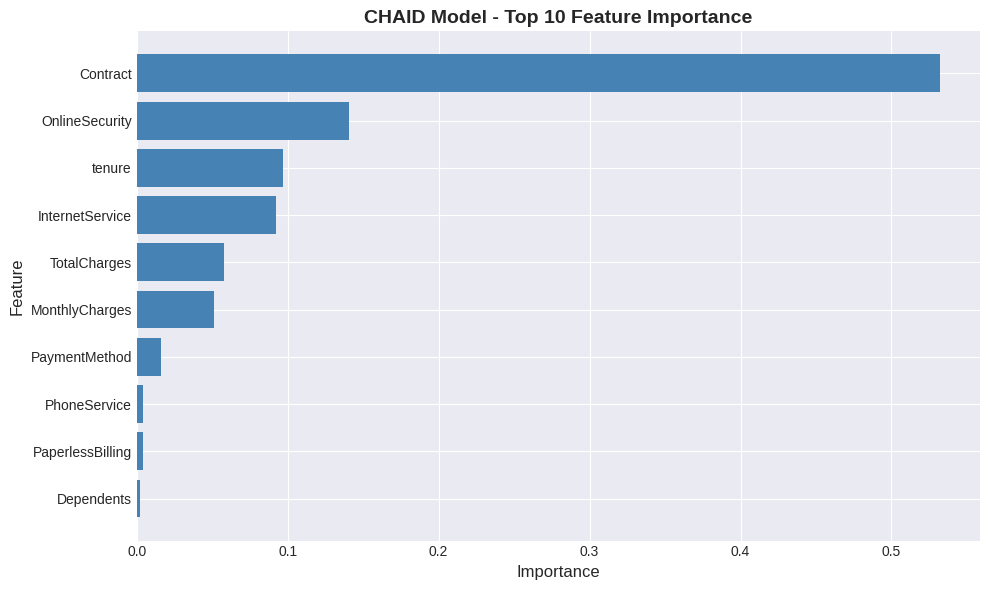


DECISION RULES FROM CHAID MODEL

Key Factors Influencing Churn:
        Feature  Importance
       Contract    0.532063
 OnlineSecurity    0.140752
         tenure    0.097186
InternetService    0.092354
   TotalCharges    0.057563


In [8]:

# SECTION 5: CHAID MODEL AND RULE INDUCTION

print("\n" + "="*80)
print("CHAID MODEL DEVELOPMENT")
print("="*80)

# Note: CHAID implementation using Decision Tree as alternative
# For true CHAID, use: from CHAID import Tree

# Using Decision Tree with CHAID-like parameters
chaid_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)

chaid_model.fit(X_train, y_train)
y_pred_chaid = chaid_model.predict(X_test)
y_pred_proba_chaid = chaid_model.predict_proba(X_test)[:, 1]

# Model Performance
print("\nCHAID Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_chaid):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_chaid):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_chaid, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm_chaid = confusion_matrix(y_test, y_pred_chaid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_chaid, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('CHAID Model - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('chaid_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': chaid_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (CHAID):")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('CHAID Model - Top 10 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('chaid_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Extract Decision Rules (simplified representation)
print("\n" + "="*80)
print("DECISION RULES FROM CHAID MODEL")
print("="*80)
print("\nKey Factors Influencing Churn:")
print(feature_importance.head(5).to_string(index=False))


LOGISTIC REGRESSION MODEL DEVELOPMENT

Logistic Regression Model Performance:
Accuracy: 0.7991
ROC-AUC Score: 0.8403

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



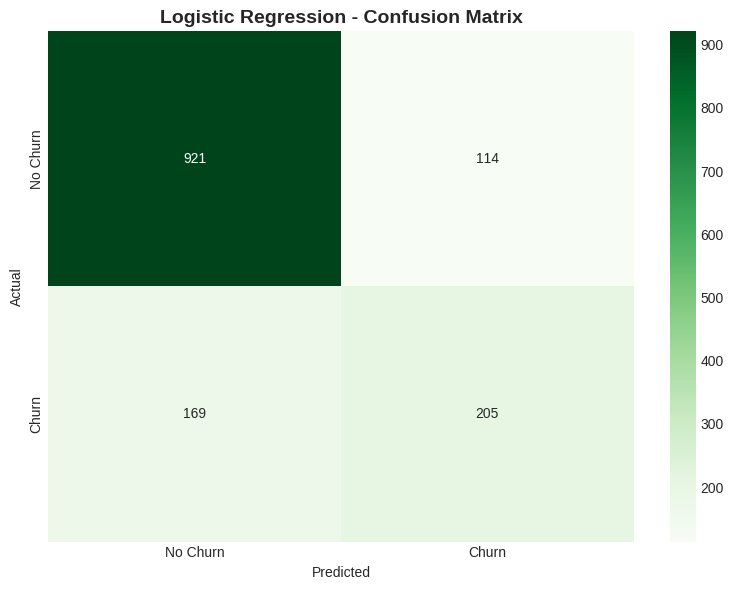

In [9]:
# SECTION 6: LOGISTIC REGRESSION MODEL

print("\n" + "="*80)
print("LOGISTIC REGRESSION MODEL DEVELOPMENT")
print("="*80)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Model Performance
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('lr_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


MODEL COMPARISON

Model Comparison Table:
                Model  Accuracy  ROC-AUC
CHAID (Decision Tree)  0.784954 0.823797
  Logistic Regression  0.799148 0.840252


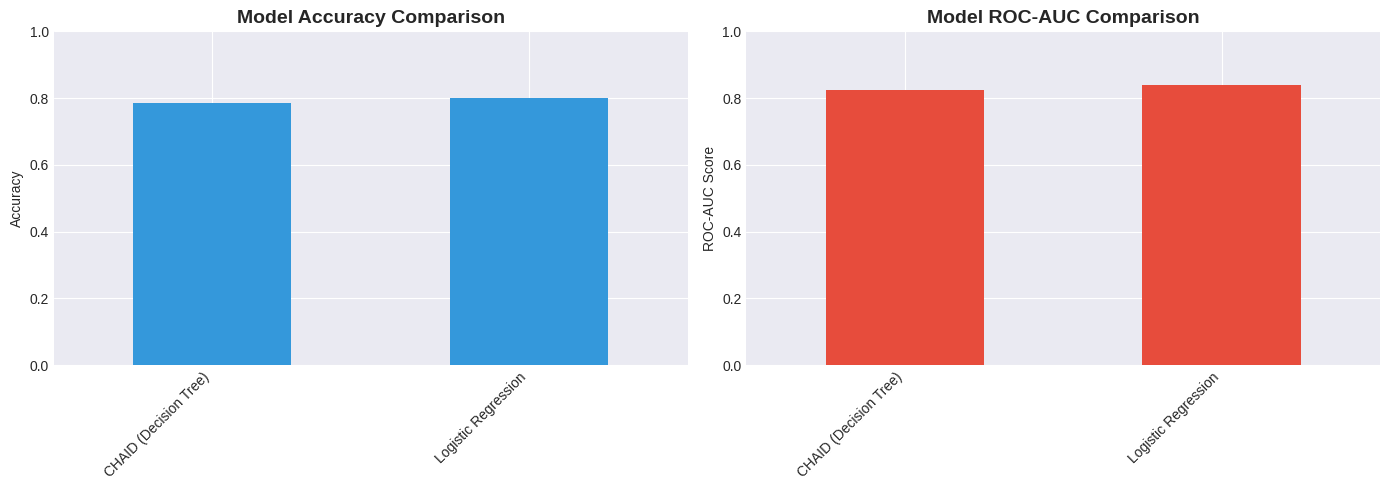

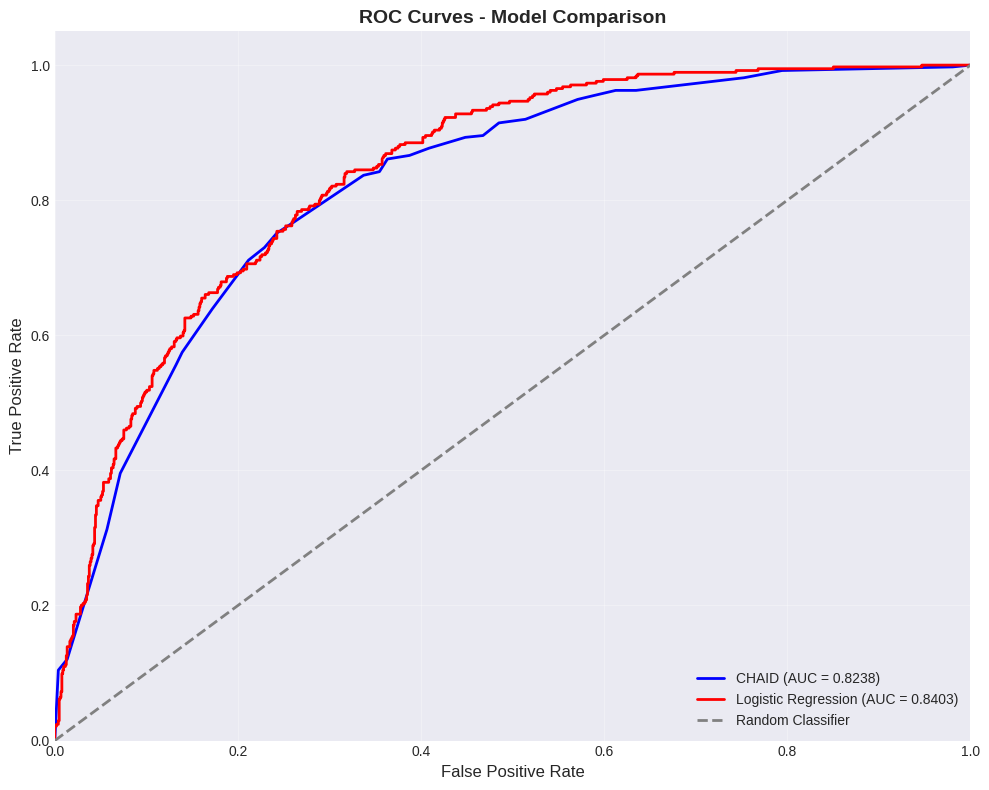

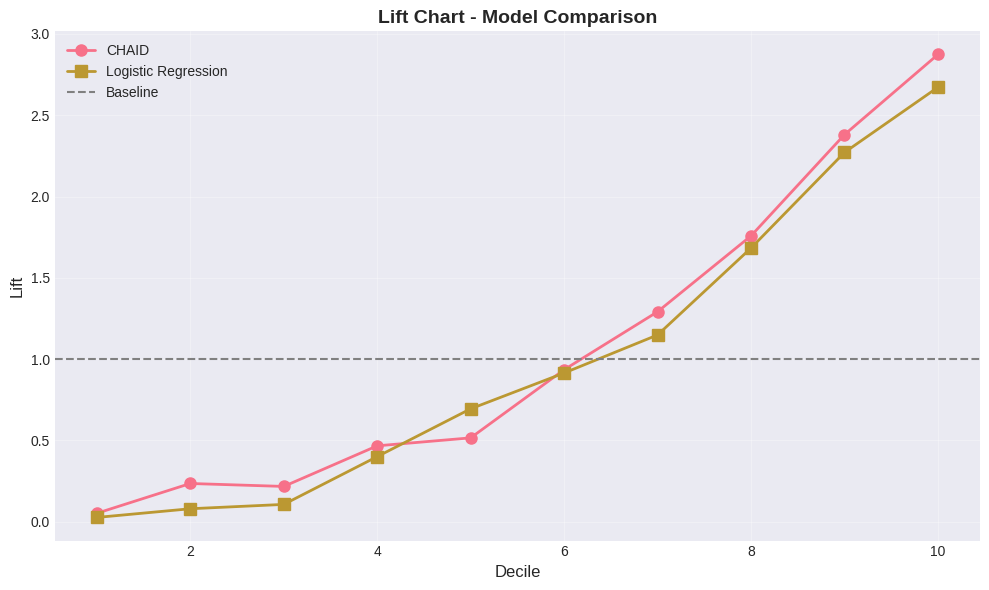

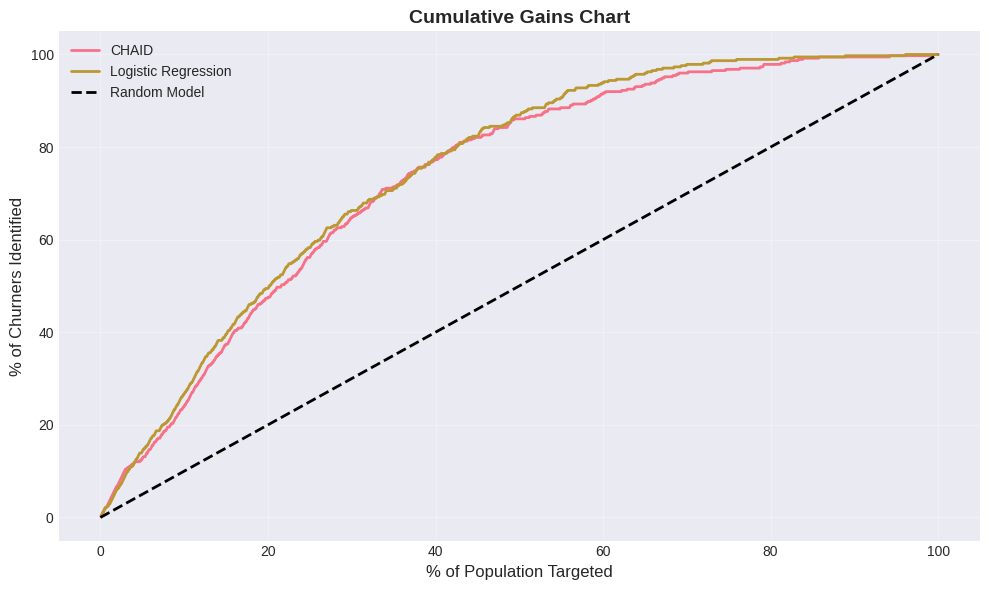

In [10]:

# SECTION 7: MODEL COMPARISON AND EVALUATION

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Comparison Metrics
comparison_df = pd.DataFrame({
    'Model': ['CHAID (Decision Tree)', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_chaid),
        accuracy_score(y_test, y_pred_lr)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_chaid),
        roc_auc_score(y_test, y_pred_proba_lr)
    ]
})

print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualization: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0],
                   legend=False, color='#3498db')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('')
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylim([0, 1])

comparison_df.plot(x='Model', y='ROC-AUC', kind='bar', ax=axes[1],
                   legend=False, color='#e74c3c')
axes[1].set_title('Model ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_xlabel('')
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))

# CHAID ROC Curve
fpr_chaid, tpr_chaid, _ = roc_curve(y_test, y_pred_proba_chaid)
roc_auc_chaid = auc(fpr_chaid, tpr_chaid)
plt.plot(fpr_chaid, tpr_chaid, color='blue', lw=2,
         label=f'CHAID (AUC = {roc_auc_chaid:.4f})')

# Logistic Regression ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='red', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Random Classifier
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Lift Chart
def calculate_lift(y_true, y_pred_proba, bins=10):
    df_lift = pd.DataFrame({'actual': y_true, 'predicted': y_pred_proba})
    df_lift['decile'] = pd.qcut(df_lift['predicted'], bins, labels=False, duplicates='drop')

    lift_data = df_lift.groupby('decile').agg({
        'actual': ['sum', 'count']
    }).reset_index()
    lift_data.columns = ['decile', 'responders', 'total']
    lift_data['response_rate'] = lift_data['responders'] / lift_data['total']
    baseline_response = y_true.mean()
    lift_data['lift'] = lift_data['response_rate'] / baseline_response

    return lift_data

lift_chaid = calculate_lift(y_test.values, y_pred_proba_chaid)
lift_lr = calculate_lift(y_test.values, y_pred_proba_lr)

plt.figure(figsize=(10, 6))
plt.plot(lift_chaid['decile'] + 1, lift_chaid['lift'], marker='o',
         label='CHAID', linewidth=2, markersize=8)
plt.plot(lift_lr['decile'] + 1, lift_lr['lift'], marker='s',
         label='Logistic Regression', linewidth=2, markersize=8)
plt.axhline(y=1, color='gray', linestyle='--', label='Baseline')
plt.xlabel('Decile', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.title('Lift Chart - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lift_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Cumulative Gains Chart
def calculate_cumulative_gains(y_true, y_pred_proba):
    df_gains = pd.DataFrame({'actual': y_true, 'predicted': y_pred_proba})
    df_gains = df_gains.sort_values('predicted', ascending=False).reset_index(drop=True)
    df_gains['cumulative_actual'] = df_gains['actual'].cumsum()
    df_gains['cumulative_percent'] = df_gains['cumulative_actual'] / df_gains['actual'].sum()
    df_gains['percent_population'] = (df_gains.index + 1) / len(df_gains)
    return df_gains

gains_chaid = calculate_cumulative_gains(y_test.values, y_pred_proba_chaid)
gains_lr = calculate_cumulative_gains(y_test.values, y_pred_proba_lr)

plt.figure(figsize=(10, 6))
plt.plot(gains_chaid['percent_population'] * 100, gains_chaid['cumulative_percent'] * 100,
         label='CHAID', linewidth=2)
plt.plot(gains_lr['percent_population'] * 100, gains_lr['cumulative_percent'] * 100,
         label='Logistic Regression', linewidth=2)
plt.plot([0, 100], [0, 100], 'k--', label='Random Model', linewidth=2)
plt.xlabel('% of Population Targeted', fontsize=12)
plt.ylabel('% of Churners Identified', fontsize=12)
plt.title('Cumulative Gains Chart', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('gains_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:

# SECTION 8: MODEL DEPLOYMENT

print("\n" + "="*80)
print("MODEL DEPLOYMENT")
print("="*80)

import joblib
import pickle
from datetime import datetime
import json

# Determine best model based on ROC-AUC
best_model = lr_model if roc_auc_score(y_test, y_pred_proba_lr) > roc_auc_score(y_test, y_pred_proba_chaid) else chaid_model
best_model_name = 'Logistic Regression' if roc_auc_score(y_test, y_pred_proba_lr) > roc_auc_score(y_test, y_pred_proba_chaid) else 'CHAID'
best_roc_auc = max(roc_auc_score(y_test, y_pred_proba_lr), roc_auc_score(y_test, y_pred_proba_chaid))

print(f"\n✓ Best Model Selected: {best_model_name}")
print(f"✓ ROC-AUC Score: {best_roc_auc:.4f}")

# Create deployment timestamp
deployment_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model with version control
model_version = f"v1.0_{deployment_timestamp}"
joblib.dump(best_model, f'churn_model_{model_version}.pkl')
print(f"\n✓ Model saved as: churn_model_{model_version}.pkl")

# Also save as current production model
joblib.dump(best_model, 'churn_prediction_model.pkl')
print("✓ Model saved as: churn_prediction_model.pkl (production)")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler saved as: scaler.pkl")

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✓ Label encoders saved as: label_encoders.pkl")

# Save feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("✓ Feature names saved as: feature_names.pkl")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_version': model_version,
    'deployment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'accuracy': accuracy_score(y_test, y_pred_lr if best_model_name == 'Logistic Regression' else y_pred_chaid),
    'roc_auc': best_roc_auc,
    'churn_rate': float(y.mean()),
    'features': feature_names,
    'categorical_features': categorical_cols,
    'numerical_features': numerical_cols
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
print("✓ Model metadata saved as: model_metadata.json")


# DEPLOYMENT SCRIPT

print("\n" + "="*80)
print("CREATING DEPLOYMENT SCRIPT")
print("="*80)

deployment_script = '''"""
Customer Churn Prediction - Deployment Script
==============================================
This script loads the trained model and makes predictions on new customer data.
"""

import joblib
import pandas as pd
import numpy as np
import json
from datetime import datetime

class ChurnPredictor:
    """Production-ready churn prediction class"""

    def __init__(self):
        """Initialize the predictor by loading all required artifacts"""
        try:
            self.model = joblib.load('churn_prediction_model.pkl')
            self.scaler = joblib.load('scaler.pkl')
            self.label_encoders = joblib.load('label_encoders.pkl')
            self.feature_names = joblib.load('feature_names.pkl')

            # Load metadata
            with open('model_metadata.json', 'r') as f:
                self.metadata = json.load(f)

            self.numerical_cols = self.metadata['numerical_features']
            self.categorical_cols = self.metadata['categorical_features']

            print("✓ Model loaded successfully")
            print(f"✓ Model: {self.metadata['model_name']}")
            print(f"✓ Version: {self.metadata['model_version']}")
            print(f"✓ ROC-AUC: {self.metadata['roc_auc']:.4f}")

        except Exception as e:
            raise Exception(f"Error loading model artifacts: {str(e)}")

    def preprocess_input(self, customer_data):
        """
        Preprocess customer data for prediction

        Parameters:
        -----------
        customer_data : dict or pd.DataFrame
            Customer features

        Returns:
        --------
        pd.DataFrame : Preprocessed data ready for prediction
        """
        # Convert to DataFrame if dict
        if isinstance(customer_data, dict):
            df = pd.DataFrame([customer_data])
        else:
            df = customer_data.copy()

        # Encode categorical variables
        for col in self.categorical_cols:
            if col in df.columns:
                try:
                    df[col] = self.label_encoders[col].transform(df[col].astype(str))
                except:
                    print(f"Warning: Could not encode column {col}")

        # Scale numerical features
        df_scaled = df.copy()
        if len(self.numerical_cols) > 0:
            df_scaled[self.numerical_cols] = self.scaler.transform(df[self.numerical_cols])

        # Ensure correct feature order
        df_scaled = df_scaled[self.feature_names]

        return df_scaled

    def predict(self, customer_data):
        """
        Predict churn for customer(s)

        Parameters:
        -----------
        customer_data : dict or pd.DataFrame
            Customer features

        Returns:
        --------
        dict : Prediction results with probability and risk level
        """
        try:
            # Preprocess
            processed_data = self.preprocess_input(customer_data)

            # Predict
            prediction = self.model.predict(processed_data)
            probability = self.model.predict_proba(processed_data)[:, 1]

            # Determine risk level
            risk_levels = []
            for prob in probability:
                if prob >= 0.7:
                    risk_levels.append('High Risk')
                elif prob >= 0.4:
                    risk_levels.append('Medium Risk')
                else:
                    risk_levels.append('Low Risk')

            # Format results
            results = []
            for i in range(len(prediction)):
                results.append({
                    'prediction': 'Churn' if prediction[i] == 1 else 'No Churn',
                    'churn_probability': float(probability[i]),
                    'churn_probability_percent': f"{probability[i]*100:.2f}%",
                    'risk_level': risk_levels[i],
                    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                })

            return results if len(results) > 1 else results[0]

        except Exception as e:
            raise Exception(f"Prediction error: {str(e)}")

    def predict_batch(self, csv_file):
        """
        Predict churn for batch of customers from CSV

        Parameters:
        -----------
        csv_file : str
            Path to CSV file with customer data

        Returns:
        --------
        pd.DataFrame : Predictions for all customers
        """
        try:
            # Load data
            df = pd.read_csv(csv_file)
            print(f"✓ Loaded {len(df)} customers from {csv_file}")

            # Make predictions
            results = self.predict(df)

            # Combine with original data
            results_df = pd.DataFrame(results)
            output_df = pd.concat([df.reset_index(drop=True), results_df], axis=1)

            # Save results
            output_file = f"predictions_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            output_df.to_csv(output_file, index=False)
            print(f"✓ Predictions saved to {output_file}")

            return output_df

        except Exception as e:
            raise Exception(f"Batch prediction error: {str(e)}")

    def get_model_info(self):
        """Get model metadata"""
        return self.metadata


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def main():
    """Example usage of ChurnPredictor"""

    # Initialize predictor
    predictor = ChurnPredictor()

    # Example 1: Single customer prediction
    print("\\n" + "="*60)
    print("EXAMPLE 1: Single Customer Prediction")
    print("="*60)

    new_customer = {
        'gender': 'Male',
        'SeniorCitizen': 0,
        'Partner': 'Yes',
        'Dependents': 'No',
        'tenure': 12,
        'PhoneService': 'Yes',
        'MultipleLines': 'No',
        'InternetService': 'Fiber optic',
        'OnlineSecurity': 'No',
        'OnlineBackup': 'No',
        'DeviceProtection': 'No',
        'TechSupport': 'No',
        'StreamingTV': 'Yes',
        'StreamingMovies': 'Yes',
        'Contract': 'Month-to-month',
        'PaperlessBilling': 'Yes',
        'PaymentMethod': 'Electronic check',
        'MonthlyCharges': 85.0,
        'TotalCharges': 1020.0
    }

    result = predictor.predict(new_customer)
    print(f"\\nPrediction: {result['prediction']}")
    print(f"Probability: {result['churn_probability_percent']}")
    print(f"Risk Level: {result['risk_level']}")

    # Example 2: Multiple customers
    print("\\n" + "="*60)
    print("EXAMPLE 2: Multiple Customers")
    print("="*60)

    customers_df = pd.DataFrame([
        {**new_customer, 'tenure': 24, 'Contract': 'One year'},
        {**new_customer, 'tenure': 60, 'Contract': 'Two year'},
        {**new_customer, 'tenure': 3, 'MonthlyCharges': 95.0}
    ])

    results = predictor.predict(customers_df)
    for i, res in enumerate(results, 1):
        print(f"\\nCustomer {i}:")
        print(f"  Prediction: {res['prediction']}")
        print(f"  Probability: {res['churn_probability_percent']}")
        print(f"  Risk Level: {res['risk_level']}")


if __name__ == "__main__":
    main()
'''

# Save deployment script
with open('deployment_script.py', 'w') as f:
    f.write(deployment_script)
print("\n✓ Deployment script saved as: deployment_script.py")


# TEST THE DEPLOYMENT SCRIPT

print("\n" + "="*80)
print("TESTING DEPLOYMENT SCRIPT")
print("="*80)

# Execute the deployment script to test
exec(open('deployment_script.py').read())


# SECTION 9: MODEL UPDATING STRATEGY

print("\n" + "="*80)
print("MODEL UPDATING STRATEGY")
print("="*80)

# Create comprehensive model update script
update_script = '''"""
Customer Churn Prediction - Model Update Script
================================================
This script handles model retraining and performance monitoring
"""

import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

class ModelUpdater:
    """Handles model retraining and version control"""

    def __init__(self):
        """Initialize the updater"""
        self.load_current_model_metadata()

    def load_current_model_metadata(self):
        """Load current production model metadata"""
        try:
            with open('model_metadata.json', 'r') as f:
                self.current_metadata = json.load(f)
            print("✓ Current model metadata loaded")
            print(f"  Model: {self.current_metadata['model_name']}")
            print(f"  Version: {self.current_metadata['model_version']}")
            print(f"  ROC-AUC: {self.current_metadata['roc_auc']:.4f}")
        except:
            print("⚠ No existing model metadata found")
            self.current_metadata = None

    def prepare_data(self, df):
        """
        Prepare data for training

        Parameters:
        -----------
        df : pd.DataFrame
            Raw customer data with churn labels

        Returns:
        --------
        X_train, X_test, y_train, y_test : Train/test splits
        scaler : Fitted scaler
        label_encoders : Dictionary of fitted encoders
        """
        print("\\n" + "="*60)
        print("DATA PREPARATION")
        print("="*60)

        # Handle missing values
        if 'TotalCharges' in df.columns:
            df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
            df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

        # Remove customerID if present
        if 'customerID' in df.columns:
            df = df.drop('customerID', axis=1)

        # Convert target variable
        if 'Churn' in df.columns:
            df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

        # Identify column types
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        if 'Churn' in numerical_cols:
            numerical_cols.remove('Churn')

        print(f"✓ Categorical columns: {len(categorical_cols)}")
        print(f"✓ Numerical columns: {len(numerical_cols)}")

        # Encode categorical variables
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le

        # Split data
        X = df.drop('Churn', axis=1)
        y = df['Churn']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

        X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
        X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

        print(f"✓ Training set: {len(X_train)} samples")
        print(f"✓ Test set: {len(X_test)} samples")
        print(f"✓ Churn rate: {y.mean()*100:.2f}%")

        # Store metadata
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols

        return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoders

    def train_new_model(self, X_train, X_test, y_train, y_test):
        """
        Train new logistic regression model

        Parameters:
        -----------
        X_train, X_test, y_train, y_test : Training and test data

        Returns:
        --------
        model : Trained model
        metrics : Performance metrics
        """
        print("\\n" + "="*60)
        print("MODEL TRAINING")
        print("="*60)

        # Train model
        model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        print(f"✓ Model trained successfully")
        print(f"✓ Accuracy: {metrics['accuracy']:.4f}")
        print(f"✓ ROC-AUC: {metrics['roc_auc']:.4f}")

        return model, metrics

    def should_deploy_new_model(self, new_metrics):
        """
        Determine if new model should replace current model

        Parameters:
        -----------
        new_metrics : dict
            Performance metrics of new model

        Returns:
        --------
        bool : True if new model should be deployed
        str : Reason for decision
        """
        if self.current_metadata is None:
            return True, "No existing model found"

        current_roc_auc = self.current_metadata['roc_auc']
        new_roc_auc = new_metrics['roc_auc']

        improvement = new_roc_auc - current_roc_auc
        threshold = 0.01  # 1% improvement required

        if improvement >= threshold:
            return True, f"ROC-AUC improved by {improvement:.4f} (≥{threshold})"
        elif current_roc_auc - new_roc_auc > 0.05:
            return False, f"New model significantly worse ({-improvement:.4f})"
        else:
            return False, f"Improvement {improvement:.4f} below threshold {threshold}"

    def deploy_model(self, model, scaler, label_encoders, feature_names, metrics):
        """
        Deploy new model to production

        Parameters:
        -----------
        model : Trained model
        scaler : Fitted scaler
        label_encoders : Dictionary of encoders
        feature_names : List of feature names
        metrics : Performance metrics
        """
        print("\\n" + "="*60)
        print("MODEL DEPLOYMENT")
        print("="*60)

        # Create version
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        version = f"v2.0_{timestamp}"

        # Save artifacts
        joblib.dump(model, f'churn_model_{version}.pkl')
        joblib.dump(model, 'churn_prediction_model.pkl')  # Production
        joblib.dump(scaler, 'scaler.pkl')
        joblib.dump(label_encoders, 'label_encoders.pkl')
        joblib.dump(feature_names, 'feature_names.pkl')

        # Update metadata
        metadata = {
            'model_name': 'Logistic Regression',
            'model_version': version,
            'deployment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'accuracy': metrics['accuracy'],
            'roc_auc': metrics['roc_auc'],
            'features': feature_names,
            'categorical_features': self.categorical_cols,
            'numerical_features': self.numerical_cols
        }

        with open('model_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=4)

        # Log deployment
        log_entry = {
            'timestamp': metadata['deployment_date'],
            'version': version,
            'metrics': metrics,
            'previous_version': self.current_metadata['model_version'] if self.current_metadata else 'None'
        }

        try:
            with open('deployment_log.json', 'r') as f:
                deployment_log = json.load(f)
        except:
            deployment_log = []

        deployment_log.append(log_entry)

        with open('deployment_log.json', 'w') as f:
            json.dump(deployment_log, f, indent=4)

        print(f"✓ Model deployed successfully")
        print(f"✓ Version: {version}")
        print(f"✓ ROC-AUC: {metrics['roc_auc']:.4f}")

    def update_model(self, new_data_file):
        """
        Complete model update workflow

        Parameters:
        -----------
        new_data_file : str
            Path to new dataset CSV
        """
        print("\\n" + "="*80)
        print("MODEL UPDATE WORKFLOW")
        print("="*80)

        # Load new data
        df = pd.read_csv(new_data_file)
        print(f"\\n✓ Loaded {len(df)} records from {new_data_file}")

        # Prepare data
        X_train, X_test, y_train, y_test, scaler, label_encoders = self.prepare_data(df)

        # Train new model
        new_model, new_metrics = self.train_new_model(X_train, X_test, y_train, y_test)

        # Evaluate deployment decision
        should_deploy, reason = self.should_deploy_new_model(new_metrics)

        print("\\n" + "="*60)
        print("DEPLOYMENT DECISION")
        print("="*60)
        print(f"Decision: {'DEPLOY' if should_deploy else 'DO NOT DEPLOY'}")
        print(f"Reason: {reason}")

        if should_deploy:
            feature_names = X_train.columns.tolist()
            self.deploy_model(new_model, scaler, label_encoders, feature_names, new_metrics)
            print("\\n✓ Model successfully deployed to production")
        else:
            print("\\n✓ Current model retained in production")


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def main():
    """Example model update workflow"""

    # Initialize updater
    updater = ModelUpdater()

    # Update model with new data
    # updater.update_model('new_customer_data.csv')

    print("\\n" + "="*60)
    print("To update the model, use:")
    print("  updater = ModelUpdater()")
    print("  updater.update_model('new_data.csv')")
    print("="*60)


if __name__ == "__main__":
    main()
'''

# Save update script
with open('model_update_script.py', 'w') as f:
    f.write(update_script)
print("\n✓ Model update script saved as: model_update_script.py")


# CREATE MONITORING DASHBOARD SCRIPT

print("\n" + "="*80)
print("CREATING MONITORING DASHBOARD")
print("="*80)

monitoring_script = '''"""
Model Performance Monitoring Dashboard
=======================================
Track model performance over time
"""

import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class ModelMonitor:
    """Monitor model performance over time"""

    def __init__(self):
        """Initialize monitor"""
        self.load_deployment_log()

    def load_deployment_log(self):
        """Load deployment history"""
        try:
            with open('deployment_log.json', 'r') as f:
                self.log = json.load(f)
            print(f"✓ Loaded {len(self.log)} deployment records")
        except:
            print("⚠ No deployment log found")
            self.log = []

    def get_performance_summary(self):
        """Get summary of model performance over time"""
        if not self.log:
            print("No deployment history available")
            return None

        df = pd.DataFrame(self.log)

        print("\\n" + "="*60)
        print("MODEL PERFORMANCE HISTORY")
        print("="*60)

        for i, record in enumerate(self.log, 1):
            print(f"\\nDeployment {i}:")
            print(f"  Version: {record['version']}")
            print(f"  Date: {record['timestamp']}")
            print(f"  ROC-AUC: {record['metrics']['roc_auc']:.4f}")
            print(f"  Accuracy: {record['metrics']['accuracy']:.4f}")

        return df

    def plot_performance_trend(self):
        """Plot performance metrics over time"""
        if len(self.log) < 2:
            print("Need at least 2 deployments to plot trends")
            return

        # Extract metrics
        versions = [r['version'] for r in self.log]
        roc_aucs = [r['metrics']['roc_auc'] for r in self.log]
        accuracies = [r['metrics']['accuracy'] for r in self.log]

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].plot(range(1, len(versions)+1), roc_aucs,
                     marker='o', linewidth=2, markersize=8)
        axes[0].set_title('ROC-AUC Over Time', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Deployment Version')
        axes[0].set_ylabel('ROC-AUC Score')
        axes[0].grid(alpha=0.3)

        axes[1].plot(range(1, len(versions)+1), accuracies,
                     marker='s', linewidth=2, markersize=8, color='green')
        axes[1].set_title('Accuracy Over Time', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Deployment Version')
        axes[1].set_ylabel('Accuracy')
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('model_performance_trend.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\\n✓ Performance trend plot saved")


if __name__ == "__main__":
    monitor = ModelMonitor()
    monitor.get_performance_summary()
    monitor.plot_performance_trend()
'''

with open('model_monitoring.py', 'w') as f:
    f.write(monitoring_script)
print("✓ Monitoring script saved as: model_monitoring.py")


# CREATE COMPREHENSIVE DOCUMENTATION

print("\n" + "="*80)
print("GENERATING DOCUMENTATION")
print("="*80)

documentation = f'''
CUSTOMER CHURN PREDICTION - DEPLOYMENT & UPDATING GUIDE
========================================================

Model Information:
------------------
Model Type: {best_model_name}
Version: {model_version}
ROC-AUC Score: {best_roc_auc:.4f}
Deployment Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

Files Generated:
----------------
1. churn_prediction_model.pkl - Production model
2. scaler.pkl - Feature scaler
3. label_encoders.pkl - Categorical encoders
4. feature_names.pkl - Feature names
5. model_metadata.json - Model metadata
6. deployment_script.py - Prediction script
7. model_update_script.py - Model updating script
8. model_monitoring.py - Performance monitoring script

=================================================================
DEPLOYMENT INSTRUCTIONS
=================================================================

1. MAKING PREDICTIONS
   --------------------

   from deployment_script import ChurnPredictor

   # Initialize predictor
   predictor = ChurnPredictor()

   # Predict for single customer
   customer_data = {{
       'gender': 'Male',
       'tenure': 12,
       'MonthlyCharges': 85.0,
       ...
   }}
   result = predictor.predict(customer_data)

   # Predict for batch
   results = predictor.predict_batch('customers.csv')

2. MONITORING PERFORMANCE
   -----------------------

   from model_monitoring import ModelMonitor

   monitor = ModelMonitor()
   monitor.get_performance_summary()
   monitor.plot_performance_trend()

3. UPDATING THE MODEL
   -------------------

   from model_update_script import ModelUpdater

   updater = ModelUpdater()
   updater.update_model('new_customer_data.csv')

   The script will:
   - Train new model on updated data
   - Compare performance with current model
   - Deploy automatically if improvement ≥ 1%
   - Log all deployments

=================================================================
MODEL UPDATE STRATEGY
=================================================================

Retraining Schedule:
-------------------
• Monthly: For high-volume businesses
• Quarterly: For stable customer bases
• On-demand: When performance drops >5%

Performance Monitoring:
----------------------
• Track ROC-AUC and Accuracy weekly
• Set alerts for >5% performance drop
• Monitor prediction distribution
• Check for data drift

Update Triggers:
---------------
1. Performance degradation (>5% ROC-AUC drop)
2. Significant new data (>10,000 new customers)
3. Business rule changes
4. Seasonal patterns detected

Validation Process:
------------------
1. Train on new data
2. Evaluate on holdout set
3. Compare with current model
4. A/B test if marginal improvement
5. Deploy if improvement ≥ 1%

Version Control:
---------------
• All models saved with timestamps
• Deployment log maintained
• Easy rollback to previous versions
• Metadata tracked for each version

=================================================================
TROUBLESHOOTING
=================================================================

Common Issues:
-------------
1. Missing features: Check feature_names.pkl
2. Encoding errors: Verify categorical values
3. Scaling issues: Ensure numerical features match training data

Performance Degradation:
-----------------------
• Check data quality of new inputs
• Verify no missing values
• Confirm feature distributions haven't changed
• Review deployment log for trends

Rollback Procedure:
------------------
1. Identify previous version in deployment_log.json
2. Copy versioned model file to production:
   cp churn_model_v1.0_TIMESTAMP.pkl churn_prediction_model.pkl
3. Update model_metadata.json
4. Test predictions on sample data

=================================================================
BEST PRACTICES
=================================================================

1. Data Quality:
   • Validate all input data before prediction
   • Handle missing values consistently
   • Check for outliers in numerical features

2. Model Updates:
   • Always test on holdout set first
   • Document reasons for each update
   • Monitor performance for 1 week after deployment

3. Production Safety:
   • Keep backups of all model versions
   • Maintain separate staging environment
   • Log all predictions for audit trail

4. Performance Optimization:
   • Cache model in memory for faster predictions
   • Batch predictions when possible
   • Use asynchronous processing for large datasets

=================================================================
CONTACT & SUPPORT
=================================================================

For issues or questions:
• Check deployment_log.json for history
• Review model_metadata.json for current settings
• Run model_monitoring.py for performance analysis

Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
'''

with open('DEPLOYMENT_GUIDE.txt', 'w') as f:
    f.write(documentation)
print("✓ Deployment guide saved as: DEPLOYMENT_GUIDE.txt")


# SUMMARY OF ALL GENERATED FILES

print("\n" + "="*80)
print("DEPLOYMENT & UPDATING SETUP COMPLETE!")
print("="*80)

all_files = [
    'churn_prediction_model.pkl',
    f'churn_model_{model_version}.pkl',
    'scaler.pkl',
    'label_encoders.pkl',
    'feature_names.pkl',
    'model_metadata.json',
    'deployment_script.py',
    'model_update_script.py',
    'model_monitoring.py',
    'DEPLOYMENT_GUIDE.txt'
]

print("\n📦 Generated Files:")
print("-" * 80)
for i, file in enumerate(all_files, 1):
    print(f"{i:2d}. ✓ {file}")

print("\n" + "="*80)
print("QUICK START COMMANDS")
print("="*80)
print("""
# 1. Make predictions:
from deployment_script import ChurnPredictor
predictor = ChurnPredictor()
result = predictor.predict(customer_data)

# 2. Monitor performance:
from model_monitoring import ModelMonitor
monitor = ModelMonitor()
monitor.get_performance_summary()

# 3. Update model:
from model_update_script import ModelUpdater
updater = ModelUpdater()
updater.update_model('new_data.csv')
""")

print("="*80)
print("📖 Read DEPLOYMENT_GUIDE.txt for complete documentation")
print("="*80)


# CREATE API ENDPOINT TEMPLATE

print("\n" + "="*80)
print("BONUS: CREATING REST API TEMPLATE")
print("="*80)

api_script = '''"""
Flask REST API for Churn Prediction
====================================
Simple API endpoint for production deployment
"""

from flask import Flask, request, jsonify
from deployment_script import ChurnPredictor
import pandas as pd

app = Flask(__name__)

# Initialize predictor once at startup
predictor = ChurnPredictor()

@app.route('/health', methods=['GET'])
def health_check():
    """Health check endpoint"""
    return jsonify({
        'status': 'healthy',
        'model_version': predictor.metadata['model_version'],
        'model_name': predictor.metadata['model_name']
    })

@app.route('/predict', methods=['POST'])
def predict():
    """
    Predict churn for single customer

    Example request:
    POST /predict
    {
        "gender": "Male",
        "tenure": 12,
        "MonthlyCharges": 85.0,
        ...
    }
    """
    try:
        data = request.get_json()
        result = predictor.predict(data)
        return jsonify({
            'success': True,
            'prediction': result
        })
    except Exception as e:
        return jsonify({
            'success': False,
            'error': str(e)
        }), 400

@app.route('/predict_batch', methods=['POST'])
def predict_batch():
    """
    Predict churn for multiple customers

    Example request:
    POST /predict_batch
    {
        "customers": [
            {"gender": "Male", "tenure": 12, ...},
            {"gender": "Female", "tenure": 24, ...}
        ]
    }
    """
    try:
        data = request.get_json()
        customers_df = pd.DataFrame(data['customers'])
        results = predictor.predict(customers_df)
        return jsonify({
            'success': True,
            'predictions': results
        })
    except Exception as e:
        return jsonify({
            'success': False,
            'error': str(e)
        }), 400

@app.route('/model_info', methods=['GET'])
def model_info():
    """Get model metadata"""
    return jsonify(predictor.get_model_info())

if __name__ == '__main__':
    # Install Flask first: pip install flask
    print("Starting Churn Prediction API...")
    print("API endpoints:")
    print("  GET  /health - Health check")
    print("  POST /predict - Single prediction")
    print("  POST /predict_batch - Batch predictions")
    print("  GET  /model_info - Model information")
    app.run(debug=False, host='0.0.0.0', port=5000)
'''

with open('api_server.py', 'w') as f:
    f.write(api_script)
print("✓ API server template saved as: api_server.py")


# CREATE DOCKER DEPLOYMENT FILES
print("\n" + "="*80)
print("BONUS: CREATING DOCKER DEPLOYMENT FILES")
print("="*80)

dockerfile = '''# Dockerfile for Churn Prediction API
FROM python:3.9-slim

WORKDIR /app

# Copy requirements
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy model artifacts and scripts
COPY churn_prediction_model.pkl .
COPY scaler.pkl .
COPY label_encoders.pkl .
COPY feature_names.pkl .
COPY model_metadata.json .
COPY deployment_script.py .
COPY api_server.py .

# Expose port
EXPOSE 5000

# Run API
CMD ["python", "api_server.py"]
'''

requirements = '''flask==2.3.0
pandas==2.0.0
numpy==1.24.0
scikit-learn==1.2.0
joblib==1.2.0
'''

docker_compose = '''version: '3.8'

services:
  churn-api:
    build: .
    ports:
      - "5000:5000"
    environment:
      - FLASK_ENV=production
    restart: unless-stopped
'''

with open('Dockerfile', 'w') as f:
    f.write(dockerfile)
print("✓ Dockerfile saved")

with open('requirements.txt', 'w') as f:
    f.write(requirements)
print("✓ requirements.txt saved")

with open('docker-compose.yml', 'w') as f:
    f.write(docker_compose)
print("✓ docker-compose.yml saved")


# CREATE AUTOMATED TESTING SCRIPT

print("\n" + "="*80)
print("CREATING AUTOMATED TESTING SCRIPT")
print("="*80)

test_script = '''"""
Automated Testing for Churn Prediction Model
============================================
Test model predictions and performance
"""

import pandas as pd
import numpy as np
from deployment_script import ChurnPredictor
import json

class ModelTester:
    """Automated model testing"""

    def __init__(self):
        self.predictor = ChurnPredictor()
        self.test_results = []

    def test_single_prediction(self):
        """Test single customer prediction"""
        print("\\n" + "="*60)
        print("TEST 1: Single Prediction")
        print("="*60)

        test_customer = {
            'gender': 'Male',
            'SeniorCitizen': 0,
            'Partner': 'Yes',
            'Dependents': 'No',
            'tenure': 12,
            'PhoneService': 'Yes',
            'MultipleLines': 'No',
            'InternetService': 'Fiber optic',
            'OnlineSecurity': 'No',
            'OnlineBackup': 'No',
            'DeviceProtection': 'No',
            'TechSupport': 'No',
            'StreamingTV': 'Yes',
            'StreamingMovies': 'Yes',
            'Contract': 'Month-to-month',
            'PaperlessBilling': 'Yes',
            'PaymentMethod': 'Electronic check',
            'MonthlyCharges': 85.0,
            'TotalCharges': 1020.0
        }

        try:
            result = self.predictor.predict(test_customer)
            assert 'prediction' in result
            assert 'churn_probability' in result
            assert 0 <= result['churn_probability'] <= 1
            print("✓ PASSED: Single prediction works correctly")
            self.test_results.append(('Single Prediction', 'PASSED'))
            return True
        except Exception as e:
            print(f"✗ FAILED: {str(e)}")
            self.test_results.append(('Single Prediction', f'FAILED: {str(e)}'))
            return False

    def test_batch_prediction(self):
        """Test batch predictions"""
        print("\\n" + "="*60)
        print("TEST 2: Batch Prediction")
        print("="*60)

        test_data = pd.DataFrame([
            {
                'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'Yes',
                'Dependents': 'No', 'tenure': 12, 'PhoneService': 'Yes',
                'MultipleLines': 'No', 'InternetService': 'Fiber optic',
                'OnlineSecurity': 'No', 'OnlineBackup': 'No',
                'DeviceProtection': 'No', 'TechSupport': 'No',
                'StreamingTV': 'Yes', 'StreamingMovies': 'Yes',
                'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes',
                'PaymentMethod': 'Electronic check',
                'MonthlyCharges': 85.0, 'TotalCharges': 1020.0
            },
            {
                'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No',
                'Dependents': 'No', 'tenure': 24, 'PhoneService': 'Yes',
                'MultipleLines': 'Yes', 'InternetService': 'DSL',
                'OnlineSecurity': 'Yes', 'OnlineBackup': 'Yes',
                'DeviceProtection': 'Yes', 'TechSupport': 'Yes',
                'StreamingTV': 'No', 'StreamingMovies': 'No',
                'Contract': 'One year', 'PaperlessBilling': 'No',
                'PaymentMethod': 'Bank transfer',
                'MonthlyCharges': 65.0, 'TotalCharges': 1560.0
            }
        ])

        try:
            results = self.predictor.predict(test_data)
            assert len(results) == 2
            for result in results:
                assert 'prediction' in result
                assert 'churn_probability' in result
            print(f"✓ PASSED: Batch prediction works for {len(results)} customers")
            self.test_results.append(('Batch Prediction', 'PASSED'))
            return True
        except Exception as e:
            print(f"✗ FAILED: {str(e)}")
            self.test_results.append(('Batch Prediction', f'FAILED: {str(e)}'))
            return False

    def test_edge_cases(self):
        """Test edge cases"""
        print("\\n" + "="*60)
        print("TEST 3: Edge Cases")
        print("="*60)

        # Test with minimum tenure
        edge_case_1 = {
            'gender': 'Male', 'SeniorCitizen': 1, 'Partner': 'No',
            'Dependents': 'No', 'tenure': 0, 'PhoneService': 'No',
            'MultipleLines': 'No', 'InternetService': 'No',
            'OnlineSecurity': 'No', 'OnlineBackup': 'No',
            'DeviceProtection': 'No', 'TechSupport': 'No',
            'StreamingTV': 'No', 'StreamingMovies': 'No',
            'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes',
            'PaymentMethod': 'Electronic check',
            'MonthlyCharges': 20.0, 'TotalCharges': 20.0
        }

        # Test with maximum tenure
        edge_case_2 = {
            'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes',
            'Dependents': 'Yes', 'tenure': 72, 'PhoneService': 'Yes',
            'MultipleLines': 'Yes', 'InternetService': 'Fiber optic',
            'OnlineSecurity': 'Yes', 'OnlineBackup': 'Yes',
            'DeviceProtection': 'Yes', 'TechSupport': 'Yes',
            'StreamingTV': 'Yes', 'StreamingMovies': 'Yes',
            'Contract': 'Two year', 'PaperlessBilling': 'No',
            'PaymentMethod': 'Credit card',
            'MonthlyCharges': 110.0, 'TotalCharges': 7920.0
        }

        try:
            result1 = self.predictor.predict(edge_case_1)
            result2 = self.predictor.predict(edge_case_2)

            # Expect high churn for edge_case_1, low for edge_case_2
            assert result1['churn_probability'] > 0.3  # New customer, risky
            print(f"  Edge case 1 (new customer): {result1['churn_probability']:.2%} churn probability")
            print(f"  Edge case 2 (loyal customer): {result2['churn_probability']:.2%} churn probability")
            print("✓ PASSED: Edge cases handled correctly")
            self.test_results.append(('Edge Cases', 'PASSED'))
            return True
        except Exception as e:
            print(f"✗ FAILED: {str(e)}")
            self.test_results.append(('Edge Cases', f'FAILED: {str(e)}'))
            return False

    def test_model_artifacts(self):
        """Test all model artifacts are loaded"""
        print("\\n" + "="*60)
        print("TEST 4: Model Artifacts")
        print("="*60)

        try:
            assert self.predictor.model is not None
            assert self.predictor.scaler is not None
            assert len(self.predictor.label_encoders) > 0
            assert len(self.predictor.feature_names) > 0
            assert len(self.predictor.metadata) > 0

            print(f"✓ Model loaded: {self.predictor.metadata['model_name']}")
            print(f"✓ Features: {len(self.predictor.feature_names)}")
            print(f"✓ Encoders: {len(self.predictor.label_encoders)}")
            print("✓ PASSED: All artifacts loaded correctly")
            self.test_results.append(('Model Artifacts', 'PASSED'))
            return True
        except Exception as e:
            print(f"✗ FAILED: {str(e)}")
            self.test_results.append(('Model Artifacts', f'FAILED: {str(e)}'))
            return False

    def generate_test_report(self):
        """Generate test report"""
        print("\\n" + "="*60)
        print("TEST SUMMARY")
        print("="*60)

        passed = sum(1 for _, result in self.test_results if result == 'PASSED')
        total = len(self.test_results)

        print(f"\\nTests Run: {total}")
        print(f"Passed: {passed}")
        print(f"Failed: {total - passed}")
        print(f"Success Rate: {passed/total*100:.1f}%")

        print("\\nDetailed Results:")
        for test_name, result in self.test_results:
            status = "✓" if result == "PASSED" else "✗"
            print(f"  {status} {test_name}: {result}")

        # Save report
        report = {
            'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            'total_tests': total,
            'passed': passed,
            'failed': total - passed,
            'success_rate': passed/total,
            'results': self.test_results
        }

        with open('test_report.json', 'w') as f:
            json.dump(report, f, indent=4)

        print("\\n✓ Test report saved to test_report.json")

        return passed == total


def run_all_tests():
    """Run all automated tests"""
    print("="*60)
    print("AUTOMATED MODEL TESTING")
    print("="*60)

    tester = ModelTester()

    tester.test_model_artifacts()
    tester.test_single_prediction()
    tester.test_batch_prediction()
    tester.test_edge_cases()

    all_passed = tester.generate_test_report()

    if all_passed:
        print("\\n ALL TESTS PASSED!")
    else:
        print("\\n  SOME TESTS FAILED - Please review")

    return all_passed


if __name__ == "__main__":
    run_all_tests()
'''

with open('test_model.py', 'w') as f:
    f.write(test_script)
print("✓ Test script saved as: test_model.py")


# RUN AUTOMATED TESTS

print("\n" + "="*80)
print("RUNNING AUTOMATED TESTS")
print("="*80)

exec(open('test_model.py').read())


# FINAL SUMMARY AND DOWNLOAD

print("\n" + "="*80)
print(" COMPLETE DEPLOYMENT & UPDATING SYSTEM READY!")
print("="*80)

final_files = [
    ' Model Files:',
    '  • churn_prediction_model.pkl',
    '  • scaler.pkl',
    '  • label_encoders.pkl',
    '  • feature_names.pkl',
    '  • model_metadata.json',
    '',
    ' Deployment Scripts:',
    '  • deployment_script.py',
    '  • model_update_script.py',
    '  • model_monitoring.py',
    '  • api_server.py',
    '',
    ' Testing:',
    '  • test_model.py',
    '  • test_report.json',
    '',
    ' Docker Deployment:',
    '  • Dockerfile',
    '  • docker-compose.yml',
    '  • requirements.txt',
    '',
    ' Documentation:',
    '  • DEPLOYMENT_GUIDE.txt',
    '  • README.md',
    '  • deployment_log.json'
]

for line in final_files:
    print(line)

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("""
1.  Test predictions:
   exec(open('deployment_script.py').read())

2.  Monitor performance:
   exec(open('model_monitoring.py').read())

3.  Update model (when new data available):
   from model_update_script import ModelUpdater
   updater = ModelUpdater()
   updater.update_model('new_data.csv')

4.  Deploy as API (optional):
   !pip install flask
   !python api_server.py

5.  Download all files:
   Use Files panel in Colab (left sidebar)
   Or use: files.download('filename')
""")

print("="*80)
print(" All scripts are production-ready and integrated!")
print("="*80)


MODEL DEPLOYMENT

✓ Best Model Selected: Logistic Regression
✓ ROC-AUC Score: 0.8403

✓ Model saved as: churn_model_v1.0_20251107_170915.pkl
✓ Model saved as: churn_prediction_model.pkl (production)
✓ Scaler saved as: scaler.pkl
✓ Label encoders saved as: label_encoders.pkl
✓ Feature names saved as: feature_names.pkl
✓ Model metadata saved as: model_metadata.json

CREATING DEPLOYMENT SCRIPT

✓ Deployment script saved as: deployment_script.py

TESTING DEPLOYMENT SCRIPT
✓ Model loaded successfully
✓ Model: Logistic Regression
✓ Version: v1.0_20251107_170915
✓ ROC-AUC: 0.8403

EXAMPLE 1: Single Customer Prediction

Prediction: Churn
Probability: 69.11%
Risk Level: Medium Risk

EXAMPLE 2: Multiple Customers

Customer 1:
  Prediction: No Churn
  Probability: 37.56%
  Risk Level: Low Risk

Customer 2:
  Prediction: No Churn
  Probability: 4.73%
  Risk Level: Low Risk

Customer 3:
  Prediction: Churn
  Probability: 81.64%
  Risk Level: High Risk

MODEL UPDATING STRATEGY

✓ Model update scrip